In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-pre

# Reading training files

In [2]:
train_clinical=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
train_peptides=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
train_proteins=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')

In [3]:
train_clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


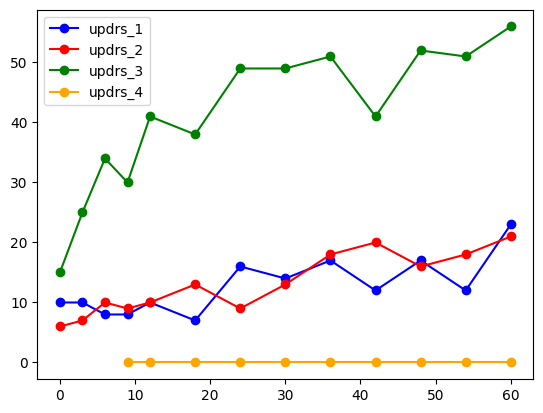

In [5]:
# Fetch data for patient with id 1517
plot_df = train_clinical[train_clinical["patient_id"]==55]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

# Dataset Preparation

In [6]:
def prepare_dataset(train_proteins, train_peptides):
    
    #grouping proteins based on visit_id and UniProt as same protein can come multiple time in visit
    df_protein_grp = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    
    #grouping proteins based on visit_id and UniProt as same protein can come multiple time in visit
    df_peptide_grp = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grp.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grp.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df
    

In [7]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

In [8]:
pro_pep_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,137611.0,6310.09,NaN,28008.8,231359.0,63265.8,64601.8,632782.0,51123.7,20700.30
